### __6) Nonlinear classifiers__ 

Try with nonlinear classi􀁿ers, can you do better than the baseline models from above?
- Try with a random Forest, does increasing the number of trees help?
- Try with SVMs - does the RBF kernel perform better than the linear one?

In [1]:
import matplotlib.image as mpimg
import glob
import numpy as np
import pandas as pd
from PIL import Image

import os
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble        import RandomForestClassifier

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC

In [2]:
data_dir = 'C:/Users/tgdreju4/OneDrive - Swisscom/EPFL/Notebooks/04ML/swissroads/'
my_dir = data_dir + 'test/'

#### Random Forest

In [3]:
with np.load(data_dir + 'train.npz', allow_pickle=False) as npz_file:
    train_data = dict(npz_file.items())

    
with np.load(data_dir + 'test.npz', allow_pickle=False) as npz_file:
    test_data = dict(npz_file.items())

with np.load(data_dir + 'valid.npz', allow_pickle=False) as npz_file:
    valid_data = dict(npz_file.items())    

class_names=['bike','car','motorcycle','other','truck','van']


# Create X/y arrays
X_tr = train_data['features']
X_te = test_data['features']
X_va = valid_data['features']
y_tr = train_data['labels']
y_te = test_data['labels']
y_va = valid_data['labels']
z_tr = train_data['files']
z_te = test_data['files']
z_va = valid_data['files']

#### Find the best number of trees (n_estimators)

In [4]:
x_estimators = [1, 5, 10, 50,100, 200, 500,1000] 
x_max_depth =  [1,5,10,20,None]

rf_estimator = []
for _estimator in x_estimators:
    for _max_depth in x_max_depth:
        dt = RandomForestClassifier(n_estimators = _estimator, 
                                    max_depth = _max_depth, 
                                    random_state=0,
                                    n_jobs=-1, 
                                    verbose=0
                                   )
        # Fit estimator
        dt.fit(X_tr, y_tr)
        # Accuracy on valid set
        accuracy = dt.score(X_va, y_va)
        #print('Accuracy: {:.3f}'.format(accuracy), ' for estimator ', estimator) # 
    
        rf_estimator.append({'nr': _estimator, 'accuracy': accuracy, 'max_depth': _max_depth, })
    


In [5]:
df  = pd.DataFrame(rf_estimator)
df.sort_values('accuracy',ascending=False).head(10)

,accuracy,max_depth,nr
19,0.920863,NaN,50
18,0.920863,20.0,50
17,0.920863,10.0,50
29,0.906475,NaN,200
28,0.906475,20.0,200
16,0.899281,5.0,50
27,0.899281,10.0,200
22,0.899281,10.0,100
33,0.892086,20.0,500
34,0.892086,NaN,500


__Result:__

> I tried different estimators (trees) together with the  RandomForest Classifier. What I see is the more trees the better the accuracy of the validation set- indendant from the max_depth value. However, the improvement decreases as the number of trees increases. At a certain point the benefit in prediction performance from learning more trees will be lower than the cost in computation time for learning these additional trees. In my case the optimal number of trees is between 100 and 500. The max_depth does not have much impact. I will chose 20.

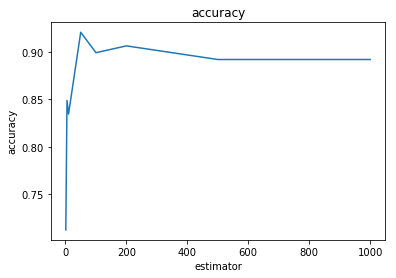

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot accuracy values
plt.plot(df[['nr','accuracy']].groupby('nr').agg(['max']).accuracy)
plt.title('accuracy')

plt.xlabel('estimator')
plt.ylabel('accuracy')
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier


# Create a RandomForestClassifier without best parameters (this is the result from the tree search)
dt = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
# Fit estimator
dt.fit(X_tr, y_tr)
# Accuracy on test set
accuracy_rf_test = dt.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy_rf_test)) # 

Accuracy: 0.940


#### Support Vector Machines

First test with linear and rbf kernel and tune parameters

In [8]:
#Set of hyperparameters for svm
gamma_val  =  [0.001, 0.01, 0.1,  1, 10, 20, 'auto'] 
gamma_val  =  ['scale'] 
c_val      = [0.01, 0.1, 1, 3,5, 10, 50, 100, 200]
#c_val      = [100]

kernel_val = ['rbf','linear']


svm_result = [] # Empty Result set

#Loop trought theses parameters
for k in kernel_val:
    
    for g in gamma_val:
        for b in c_val:

            svm_loop = SVC(kernel=k, C=b, gamma=g)
            svm_loop.fit(X_tr, y_tr) # Fit
        
            svm_result.append({  # Add the parameters and the valid and test score
                'kernel' : k,
                'gamma': g,
                'C': b,
                'valid_accuracy': svm_loop.score(X_va, y_va)
                
            })



Results of SVM

In [9]:
# Convert results to DataFrame
svm_result = pd.DataFrame(svm_result)

# Top ten parameters for linear kernel
svm_result[svm_result.kernel == 'linear'].sort_values(by='valid_accuracy', ascending=False).head(10)


,C,gamma,kernel,valid_accuracy
9,0.01,scale,linear,0.892086
10,0.10,scale,linear,0.884892
11,1.00,scale,linear,0.884892
12,3.00,scale,linear,0.884892
13,5.00,scale,linear,0.884892
14,10.00,scale,linear,0.884892
15,50.00,scale,linear,0.884892
16,100.00,scale,linear,0.884892
17,200.00,scale,linear,0.884892


In [10]:
# Top ten parameters for rbf kernel
svm_result[svm_result.kernel == 'rbf'].sort_values(by='valid_accuracy', ascending=False).head(10)

,C,gamma,kernel,valid_accuracy
3,3.00,scale,rbf,0.928058
4,5.00,scale,rbf,0.928058
5,10.00,scale,rbf,0.928058
6,50.00,scale,rbf,0.928058
7,100.00,scale,rbf,0.928058
8,200.00,scale,rbf,0.928058
2,1.00,scale,rbf,0.920863
1,0.10,scale,rbf,0.669065
0,0.01,scale,rbf,0.237410


__Result:__

> rbf kernel vs linear kernal: on the validation set the rbf kernel performs better than the linear kernal. See the accuracy values above in the dataframe list.

Calculate accuracy on test set

In [11]:
from sklearn.svm import SVC
# Create SVM with RBF kernel
rbf_svc = SVC(kernel='rbf', C=3,gamma = 'scale')
# Fit estimator
rbf_svc.fit(X_tr, y_tr)
# Accuracy on test set
accuracy_rbf_valid = rbf_svc.score(X_va, y_va)
accuracy_rbf_test = rbf_svc.score(X_te, y_te)
print('Valid accuracy with rbf kernel: {:.1f}%'.format(100*accuracy_rbf_valid)) # 
print('Test accuracy with rbf kernel:  {:.1f}%'.format(100*accuracy_rbf_test)) # 

Valid accuracy with rbf kernel: 92.8%
Test accuracy with rbf kernel:  94.0%


In [12]:
from sklearn.svm import SVC
# Create SVM with RBF kernel
linear_svc = SVC(kernel='linear', C=0.01,gamma = 'scale')
# Fit estimator
linear_svc.fit(X_tr, y_tr)
# Accuracy on test set
accuracy_linear_valid = linear_svc.score(X_va, y_va)
accuracy_linear_test = linear_svc.score(X_te, y_te)
print('Valid accuracy with rbf kernel: {:.1f}%'.format(100*accuracy_linear_valid)) # 
print('Test accuracy with rbf kernel:  {:.1f}%'.format(100*accuracy_linear_test)) # 

Valid accuracy with rbf kernel: 89.2%
Test accuracy with rbf kernel:  94.0%


In [13]:
# Load the pickle file
df = pd.read_csv(data_dir + 'data.csv', index_col=0)
df = df.append({
       'model':         'smv linear',
       'test accuracy': accuracy_linear_test
            },ignore_index=True)  
df = df.append({
       'model':         'smv rbf',
       'test accuracy': accuracy_rbf_test
            },ignore_index=True)  

df = df.append({
       'model':         'random forest',
       'test accuracy': accuracy_rf_test
            },ignore_index=True)  

df.to_csv(data_dir + 'data.csv')
# read all results from csv and print 
df = pd.read_csv(data_dir + 'data.csv', index_col=0)
df

,model,test accuracy
0,knn,0.84
1,decision tree,0.90
2,Logistic,0.94
3,smv linear,0.94
4,smv rbf,0.94
5,random forest,0.94
